In [1]:
import pdb
import os
import cv2
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
from albumentations import (Normalize, Compose)
from albumentations.pytorch import ToTensor
import torch.utils.data as data
from Resnet_UNet import ResNetUNet
from Data_Retriever_Inference_Real_Time import TestDataset
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [3]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((224, 224), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [4]:
test_data_folder = "./test_images"
fname = "003c5da97.jpg"

In [5]:
# initialize test dataloader
best_threshold = 0.5
num_workers = 2
batch_size = 1
print('best_threshold', best_threshold)
min_size = 3500
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
testset = DataLoader(
    TestDataset(test_data_folder, fname, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

best_threshold 0.5


In [6]:
# Initialize mode and load trained weights
ckpt_path = "model.pth"
device = torch.device("cuda:0,1" if torch.cuda.is_available() else "cpu")
model = ResNetUNet(n_class=4)
model = nn.DataParallel(model)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
#print(state["state_dict"])
model.load_state_dict(state["state_dict"])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [7]:
# start prediction
predictions = []
for i, batch in enumerate(tqdm(testset)):
    fnames, images = batch
    batch_preds = torch.sigmoid(model(images.to(device)))
    batch_preds = batch_preds.detach().cpu().numpy()
    for fname, preds in zip(fnames, batch_preds):
        for cls, pred in enumerate(preds):
            pred, num = post_process(pred, best_threshold, min_size)
            rle = mask2rle(pred)
            name = fname + f"_{cls+1}"
            predictions.append([name, rle])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]


In [8]:
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249,50,12)]

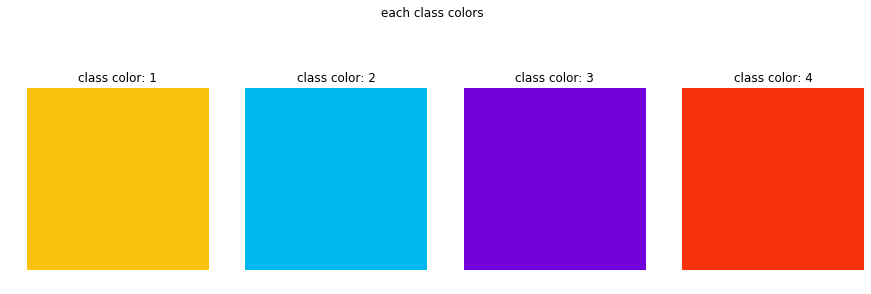

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.ones((50, 50, 3), dtype=np.uint8) * palet[i])
    ax[i].set_title("class color: {}".format(i+1))
fig.suptitle("each class colors")

plt.show()

In [10]:
def name_and_mask(ls):
    img_names = [str(ele[0]).split("_")[0] for ele in ls]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3]):
        raise ValueError

    labels = [ele[1] for ele in ls]
    mask = np.zeros((224, 224, 4), dtype=np.uint8)

    for idx, label in enumerate(labels):
        if label != '':
            mask_label = np.zeros(224*224, dtype=np.uint8)
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            for pos, le in zip(positions, length):
                mask_label[pos-1:pos+le-1] = 1
            mask[:, :, idx] = mask_label.reshape(224, 224, order='F')
    return img_names[0], mask

In [11]:
def show_mask_image(col):
    name, mask = name_and_mask(col)
    train_path = './test_images'
    img = cv2.imread(os.path.join(train_path, name))
    fig, ax = plt.subplots(figsize=(15, 15))

    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(0, len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)
    ax.set_title(name)
    ax.imshow(img)
    plt.show()

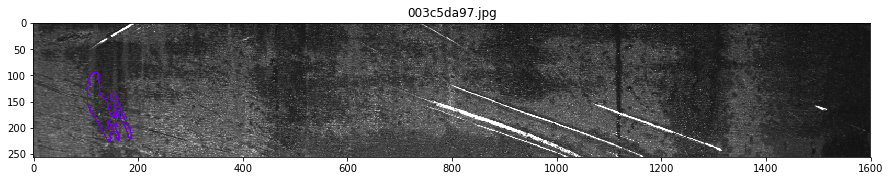

In [12]:
show_mask_image(predictions)